# Постановка задачи

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.

## Загрузка данных и парсинг дат проведения передачи

In [1]:
import pandas as pd
import requests
import seaborn as sns
import numpy as np

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from prophet import Prophet
from sklearn.cluster import DBSCAN

In [2]:
tea_df = pd.read_csv('tea_demand.csv', sep = '\t')
tea_df.head(6)

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185
5,29,2016-07-02,580


In [3]:
# переводим дату к формату datetime
tea_df['date'] = pd.to_datetime(tea_df['date'])

# проверяем период датасета
tea_df['date'].min(), tea_df['date'].max()

(Timestamp('2016-07-01 00:00:00'), Timestamp('2016-11-30 00:00:00'))

Создадим для каждого бренда отдельный датафрейм:
* lipton — 29;
* ahmad — 178;
* may — 5152.

In [4]:
# lipton
lipton_df = tea_df[tea_df['brand_id'] == 29].rename(
    columns = {'receipts_count': 'sales'}
)[['date', 'sales']].reset_index(drop = True)

# ahmad
ahmad_df = tea_df[tea_df['brand_id'] == 178].rename(
    columns = {'receipts_count': 'sales'}
)[['date', 'sales']].reset_index(drop = True)

# may
may_df = tea_df[tea_df['brand_id'] == 5152].rename(
    columns = {'receipts_count': 'sales'}
)[['date', 'sales']].reset_index(drop = True)

# убедимся, что количество дат совпадает
print(len(lipton_df) == len(ahmad_df) == len(may_df))
ahmad_df.head()

True


,date,sales
0,2016-07-01,234
1,2016-07-02,185
2,2016-07-03,190
3,2016-07-04,196
4,2016-07-05,336


Нам понадобятся данные о датах проведения передачи «Что? Где? Когда?» за 2016 год.

In [5]:
# загружаем данные с сайта «Что? Где? Когда?»
response = requests.get('https://chgk.tvigra.ru/letopis/?2016')
soup = BeautifulSoup(response.text, 'html.parser')

dates = []
for string in soup.find_all('li'):
    dates.append(string.get_text().split('\n')[0])

games = pd.Series(dates, name = 'date')
games.values

array(['27 марта', '3 апреля', '10 апреля', '17 апреля', '24 апреля',
       '15 мая', '22 мая', '29 мая', '5 июня', '19 июня', '25 сентября',
       '2 октября', '9 октября', '16 октября', '23 октября', '20 ноября',
       '27 ноября', '11 декабря', '18 декабря', '25 декабря'],
      dtype=object)

In [6]:
# приводим к фомрату datetime
months = {
    'марта': '3',
    'апреля': '4',
    'мая': '5',
    'июня': '6',
    'сентября': '9',
    'октября': '10',
    'ноября': '11',
    'декабря': '12'
}
games = pd.to_datetime(
    games
    .apply(lambda x: '2016-' + months[x.split()[1]] + '-' + x.split()[0])
)

# оставим только период, за который есть данные о продажах
games = games[
    (games >= tea_df['date'].min()) & (games <= tea_df['date'].max())
].reset_index(drop = True)
games

,date
0,2016-09-25
1,2016-10-02
2,2016-10-09
3,2016-10-16
4,2016-10-23
5,2016-11-20
6,2016-11-27


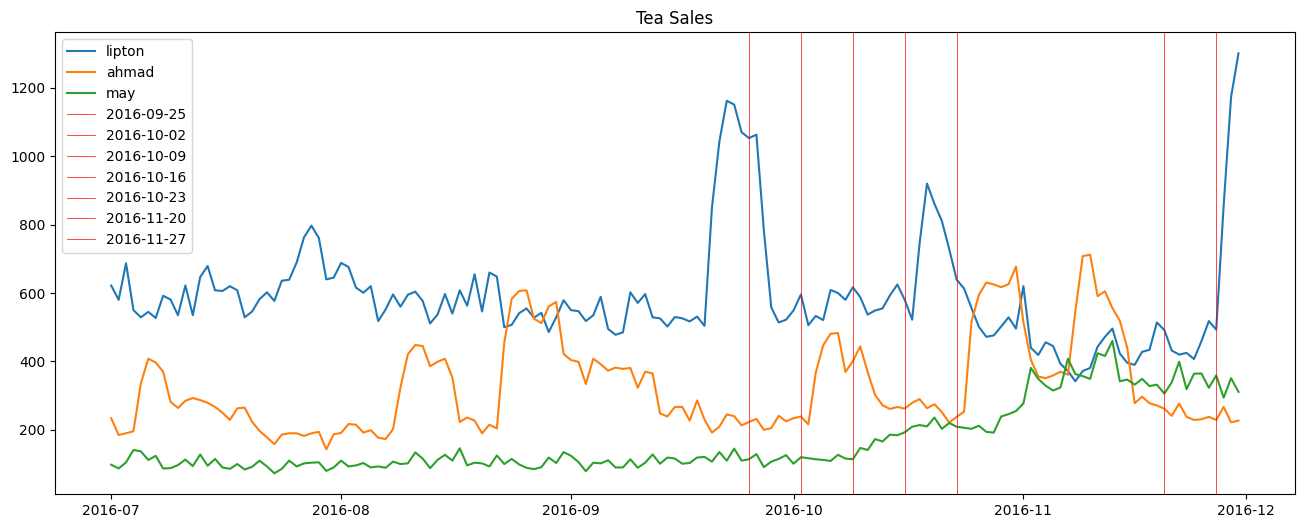

In [7]:
# отразим полученные данные на графике
f, ax = plt.subplots(figsize = (16, 6))
ax.plot(lipton_df['date'], lipton_df['sales'], label = 'lipton')
ax.plot(ahmad_df['date'], ahmad_df['sales'], label = 'ahmad')
ax.plot(may_df['date'], may_df['sales'], label = 'may')

for i in range(len(games)):
    ax.axvline(games[i], lw = 0.5, c = 'r', label = str(games[i]).split()[0])

ax.set_title('Tea Sales')
ax.legend();

На первый взглад можно предположить, что имеется некоторый тренд на увеличения продаж чая «Ахмад» и «Май» с наступлением холодов. У чая «Липтон» такого тренда не наблюдается - возможно это связано с тем, что в продажах чая «Липтон» есть доля холодных напитков.

## Cтатистические методы детектирования аномалий

Количество аномалий: 3


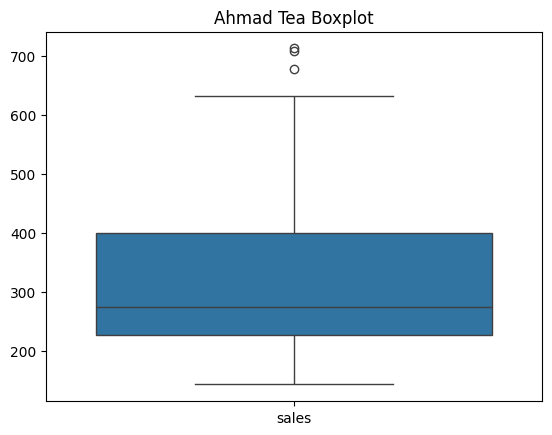

In [8]:
# построим boxplot для данных чая Ахмад
boxplot = sns.boxplot(data = ahmad_df)
boxplot.set_title('Ahmad Tea Boxplot')

# получаем количества аномалий
outliers = boxplot.get_children()[6].get_ydata()
count_outliers = len(outliers)

print("Количество аномалий:", count_outliers)

Если мы посмотрим на предыдущий график с результатами продаж, то увидим, что 3 максимальных значания для чая Ахмад приходится на период когда игры не проходили, а значит вряд ли реклама могла повлиять на этот результат. К тому же схожее поведение мы видим в августе - сентябре, что может объясняться сезонностью.

## Предсказание значений временного ряда

Попробуем обучить модель, предсказывающую значение временного ряда продаж чая Ахмад. Для обучения модели возьмём часть данных до проведения первой передачи «Что? Где? Когда?». Для предсказывания продолжительного периода времени подойдёт библиотека prophet.

In [9]:
# подготавливаем данные
ahmad_train = ahmad_df[ahmad_df['date'] < games.min()].reset_index(drop = True)
ahmad_train.columns = ['ds', 'y']
ahmad_train.head()

,ds,y
0,2016-07-01,234
1,2016-07-02,185
2,2016-07-03,190
3,2016-07-04,196
4,2016-07-05,336


In [10]:
# обучаем модель с довавлением месячной сезонности
model = Prophet(changepoint_prior_scale = 0.06)
model.add_seasonality(name = 'monthly', period = 31, fourier_order = 6)
model.fit(ahmad_train)

# делаем предсказания
future = model.make_future_dataframe(periods = len(ahmad_df) - len(ahmad_train))
forecast = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqf4hxh9a/16k1uv0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqf4hxh9a/y8la0b55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92722', 'data', 'file=/tmp/tmpqf4hxh9a/16k1uv0_.json', 'init=/tmp/tmpqf4hxh9a/y8la0b55.json', 'output', 'file=/tmp/tmpqf4hxh9a/prophet_modelcxava97q/prophet_model-20240921135555.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:55:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


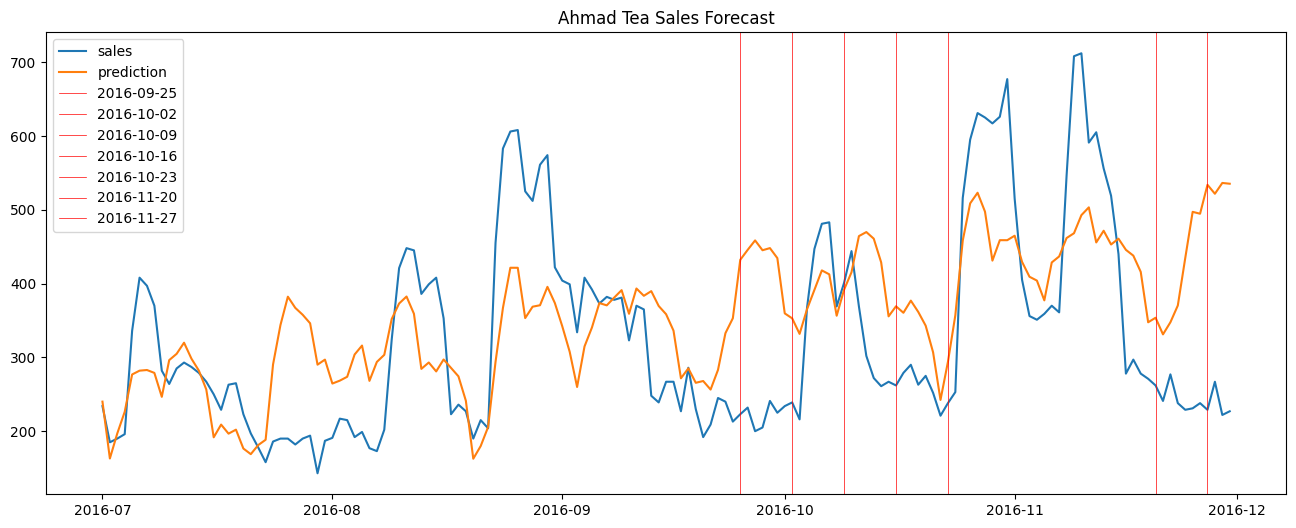

In [11]:
# отобразим полученные данные на графике
f, ax = plt.subplots(figsize = (16, 6))
ax.plot(ahmad_df['date'], ahmad_df['sales'], label = 'sales')
ax.plot(forecast['ds'], forecast['yhat'], label = 'prediction')

for i in range(len(games)):
    ax.axvline(games[i], lw = 0.5, c = 'r', label = str(games[i]).split()[0])

ax.set_title('Ahmad Tea Sales Forecast')
ax.legend();

Предсказания обученной модели подтвердили предположение о сезонном повышении объёма продаж на ноябрь 2016 года. Да, эти значения не так велики как пиковые, но всё же мы не можем принять гипотезу, о влиянии рекламы в передаче «Что? Где? Когда?» на объёмы продаж чая «Ахмад».

Также мы видим, что в дни показа рекламы и на следующий день почти все предсказанные значения больше, чем фактические.  
Проверим это арифметически:

In [12]:
# выделяем индексы
ahmad_game_days = ahmad_df[ahmad_df['date'].isin(games)].index
ahmad_next_days = ahmad_game_days + 1

# сравниваем значения в день показа рекламы
game_days_diff = pd.concat([
    ahmad_df.loc[ahmad_game_days],
    forecast.loc[ahmad_game_days]['yhat'].astype(int)
], axis = 1)
game_days_diff['diff'] = game_days_diff['yhat'] - game_days_diff['sales']
print('Total difference:', game_days_diff['diff'].sum())
game_days_diff

Total difference: 869


,date,sales,yhat,diff
86,2016-09-25,223,432,209
93,2016-10-02,239,352,113
100,2016-10-09,401,391,-10
107,2016-10-16,262,369,107
114,2016-10-23,238,293,55
142,2016-11-20,262,353,91
149,2016-11-27,229,533,304


In [13]:
# сравниваем значения на следующий день
next_days_diff = pd.concat([
    ahmad_df.loc[ahmad_next_days],
    forecast.loc[ahmad_next_days]['yhat'].astype(int)
], axis = 1)
next_days_diff['diff'] = next_days_diff['yhat'] - next_days_diff['sales']
print('Total difference:', next_days_diff['diff'].sum())
next_days_diff

Total difference: 828


,date,sales,yhat,diff
87,2016-09-26,232,445,213
94,2016-10-03,216,331,115
101,2016-10-10,444,415,-29
108,2016-10-17,279,360,81
115,2016-10-24,253,357,104
143,2016-11-21,241,331,90
150,2016-11-28,267,521,254


## Детектирование аномалий с помощью кластеризации

Попробуем проанализировать, какие аномалии мы можем найти с помощью DBSCAN кластеризации исходного датасета.

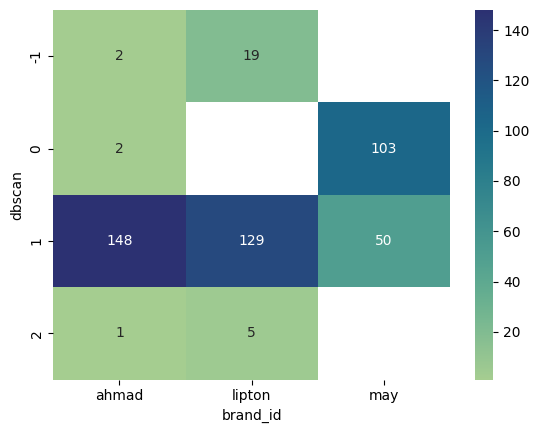

In [14]:
# подбираем eps так, чтобы получилось 3 кластера + аномалии
dbscan = DBSCAN(eps = 12)
tea_df['dbscan'] = dbscan.fit_predict(
    tea_df['receipts_count']
    .values
    .reshape(-1, 1)
)

# создаём таблицу распределения классов по чайным брендам
tea_df['brand_id'] = tea_df['brand_id'].map(
    {29: 'lipton', 178: 'ahmad', 5152: 'may'}
)
dbscan_classes = pd.pivot_table(
    tea_df,
    index = 'dbscan',
    columns = 'brand_id',
    values = 'receipts_count',
    aggfunc = 'count'
)

# отображаем полученные данные на графике
sns.heatmap(dbscan_classes, annot = True, fmt = '.0f', cmap = 'crest');

К сожалению, с помощью DBSCAN не получилось качественно разделить данные по брендам чая: Ахмад и Липтон попали в один класс, а Май разбился на два класса. Класс номер 2 остался почти без чая :)

В аномалии попали только высокие значения:

In [15]:
print('Медианное значение:', tea_df['receipts_count'].mode()[0])
print(
    'Минимальное значение аномалий:',
    tea_df[tea_df['dbscan'] == -1]['receipts_count'].min()
)

Медианное значение: 110
Минимальное значение аномалий: 708


2 аномалии найденные DBSCAN-ом среди продаж чая «Ахмад» совпадают с выбросами найденными с помощью boxplot:

In [16]:
print('DBSCAN выбросы:', tea_df[
    (tea_df['brand_id'] == 'ahmad') & (tea_df['dbscan'] == -1)
]['receipts_count'].values)
print('Boxplot выбросы:', outliers)

DBSCAN выбросы: [708 712]
Boxplot выбросы: [677. 708. 712.]


## Выводы

Маркетинговая компания в виде рекламы чая «Ахмад» в передаче «Что? Где? Когда?» вероятнее всего не оказывает нужного эффекта.